Las redes LSTM (Long Short-Term Memory) son un tipo de arquitectura de red neuronal recurrente (RNN) diseñada para abordar el problema de la desaparición del gradiente en el entrenamiento de secuencias largas. En el contexto de la clasificación de texto multi-clase, las redes LSTM destacan por su capacidad para capturar dependencias temporales y contextuales en las secuencias de palabras.

En una tarea de clasificación de texto multi-clase, las redes LSTM procesan las palabras de una secuencia de entrada una por una, manteniendo una memoria a largo plazo que les permite recordar información relevante a lo largo de la secuencia. Esta capacidad para modelar dependencias a largo plazo resulta especialmente beneficiosa en tareas donde la comprensión del contexto es esencial.

Las capas LSTM utilizan compuertas internas para decidir qué información debe mantenerse, olvidarse o actualizar en la memoria. Al aprender automáticamente estas ponderaciones, las redes LSTM pueden discernir patrones complejos y representar relaciones semánticas en el texto, lo que las convierte en una elección poderosa para la clasificación de texto en categorías múltiples.

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, BatchNormalization
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GlobalMaxPooling1D, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model

import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv("df_instruments_reviews_withTransformations.csv")

In [3]:
df.shape

(10254, 4)

In [4]:
df.head()

,Unnamed: 0,Text,overall,summary
0,0,"Not much to write about here, but it does exac...",Positive,good
1,1,The product does exactly as it should and is q...,Positive,Jake
2,2,The primary job of this device is to block the...,Positive,It Does The Job Well
3,3,Nice windscreen protects my MXL mic and preven...,Positive,GOOD WINDSCREEN FOR THE MONEY
4,4,This pop filter is great. It looks and perform...,Positive,No more pops when I record my vocals.


In [5]:
df = df.drop(columns=['Unnamed: 0', 'summary'], axis=1)

In [6]:
df['overall'].value_counts()

overall
Positive    9015
Neutral      772
Negative     467
Name: count, dtype: int64

# LSTM model

In [7]:
g = []

for i in df['Text']:
    g.append(i)

len(g)

10254

In [8]:
maxl = max([len(s) for s in g])
print ('Maximum sequence length in the list of sentences:', maxl)

Maximum sequence length in the list of sentences: 11310


## Tokenizer

In [9]:
# Importa la clase Tokenizer de Keras
from keras.preprocessing.text import Tokenizer

# Crea un objeto Tokenizer con un límite de 50,000 palabras y especifica algunos filtros de caracteres
tokenizer = Tokenizer(num_words=50000, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)

# Ajusta el Tokenizer al texto en la columna 'text' del DataFrame df
tokenizer.fit_on_texts(df['Text'].values)

# Obtiene el índice de palabras del Tokenizer
word_index = tokenizer.word_index

# Imprime el número de palabras únicas encontradas en el texto
print('Se encontraron %s tokens únicos.' % len(word_index))


Se encontraron 21622 tokens únicos.


In [10]:
X = tokenizer.texts_to_sequences(df['Text'].values)
X = pad_sequences(X, maxlen=3000)

In [11]:
y = pd.get_dummies(df['overall'],columns=df["overall"]).values
y

array([[False, False,  True],
       [False, False,  True],
       [False, False,  True],
       ...,
       [False, False,  True],
       [False, False,  True],
       [False, False,  True]])

## Split

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [28]:
print(f'X_train.shape: {X_train.shape}, y_train.shape:  {y_train.shape}')
print(f'X_test.shape: {X_test.shape}, y_test.shape:  {y_test.shape}')

X_train.shape: (7177, 3000), y_train.shape:  (7177, 3)
X_test.shape: (3077, 3000), y_test.shape:  (3077, 3)


## Model

In [14]:
from sklearn.utils.class_weight import compute_class_weight

In [15]:
np.unique(y)

array([False,  True])

In [53]:


# Calcula los pesos de clase
def calculate_class_weights(y):
    class_weights = {}
    class_counts = np.bincount(np.argmax(y, axis=1))
    total_samples = np.sum(class_counts)
    for i, count in enumerate(class_counts):
        class_weights[i] = total_samples / (len(class_counts) * count)
    return class_weights

# Obtén los pesos de clase
class_weights = calculate_class_weights(y_train)


In [56]:
NB_FEATURES = len(X_train[1])
NB_CLASSES = len(y_train[1])

In [33]:
# model = Sequential()
# model.add(Embedding(50000, 100, input_length=NB_FEATURES))
# model.add(SpatialDropout1D(0.2))
# model.add(LSTM(128, return_sequences=True))
# model.add(Dropout(0.5))
# model.add(tf.keras.layers.LSTM(64, return_sequences=True))
# model.add(tf.keras.layers.Dropout(0.5))
# model.add(tf.keras.layers.LSTM(64, return_sequences=False))
# model.add(Dense(NB_CLASSES, activation='softmax'))



In [57]:
model = Sequential()
model.add(Embedding(50000, 100, input_length=NB_FEATURES))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(GlobalMaxPooling1D()) #Pooling Layer decreases sensitivity to features, thereby creating more generalised data for better test results.
model.add(Dense(1024))
model.add(Dropout(0.25)) #Dropout layer nullifies certain random input values to generate a more general dataset and prevent the problem of overfitting.
model.add(Dense(512))
model.add(Dropout(0.25))
model.add(Dense(256))
model.add(Dropout(0.25))
model.add(Dense(128))
model.add(Dropout(0.25))
model.add(Dense(64))
model.add(Dropout(0.25))
model.add(Dense(NB_CLASSES, activation='softmax')) #softmax is used as the activation function for multi-class classification problems where class membership is required on more than two class labels.

In [58]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 3000, 100)         5000000   
                                                                 
 bidirectional_4 (Bidirecti  (None, 3000, 256)         234496    
 onal)                                                           
                                                                 
 bidirectional_5 (Bidirecti  (None, 3000, 128)         164352    
 onal)                                                           
                                                                 
 global_max_pooling1d_2 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_14 (Dense)            (None, 1024)              132096    
                                                      

In [59]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [60]:
callbacks = [
    EarlyStopping(     #EarlyStopping is used to stop at the epoch where val_accuracy does not improve significantly
        monitor='val_accuracy',
        min_delta=1e-4,
        patience=4,
        verbose=1
    )
]

In [61]:
%%time
history = model.fit (X_train, y_train, epochs = 20, batch_size = 64, validation_split = 0.2, class_weight=class_weight)

Epoch 1/20
90/90 [==============================] - 61s 579ms/step - loss: 1.0984 - accuracy: 0.3064 - val_loss: 1.2795 - val_accuracy: 0.0829
Epoch 2/20
90/90 [==============================] - 52s 580ms/step - loss: 0.9788 - accuracy: 0.6556 - val_loss: 0.6721 - val_accuracy: 0.7368
Epoch 3/20
90/90 [==============================] - 51s 565ms/step - loss: 0.7253 - accuracy: 0.7976 - val_loss: 0.5299 - val_accuracy: 0.8085
Epoch 4/20
90/90 [==============================] - 48s 538ms/step - loss: 0.4573 - accuracy: 0.8694 - val_loss: 0.5599 - val_accuracy: 0.8224
Epoch 5/20
90/90 [==============================] - 47s 519ms/step - loss: 0.3109 - accuracy: 0.9166 - val_loss: 1.1366 - val_accuracy: 0.5292
Epoch 6/20
90/90 [==============================] - 48s 530ms/step - loss: 0.2242 - accuracy: 0.9314 - val_loss: 0.5675 - val_accuracy: 0.8377
Epoch 7/20
90/90 [==============================] - 47s 522ms/step - loss: 0.1173 - accuracy: 0.9639 - val_loss: 0.8948 - val_accuracy: 0.7987

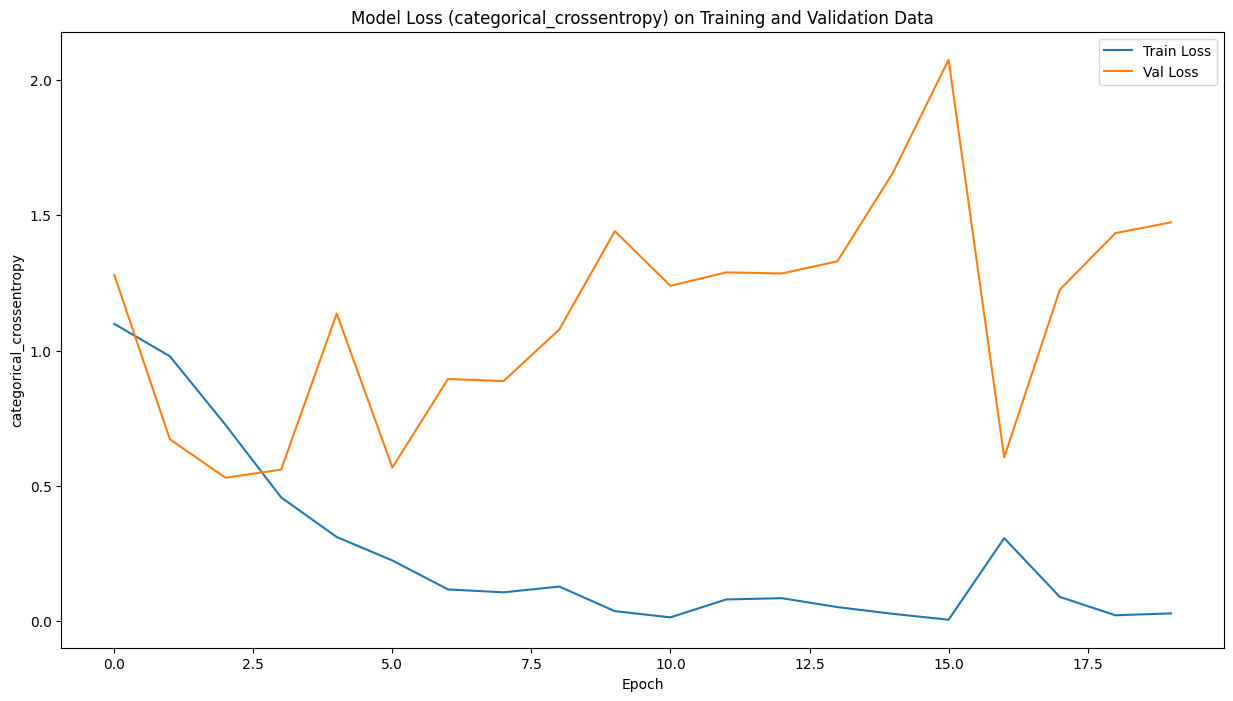

In [62]:

plt.figure(figsize=(15,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss (categorical_crossentropy) on Training and Validation Data')
plt.ylabel('categorical_crossentropy')
plt.xlabel('Epoch')
plt.legend(['Train Loss','Val Loss' ], loc='upper right')
plt.show()

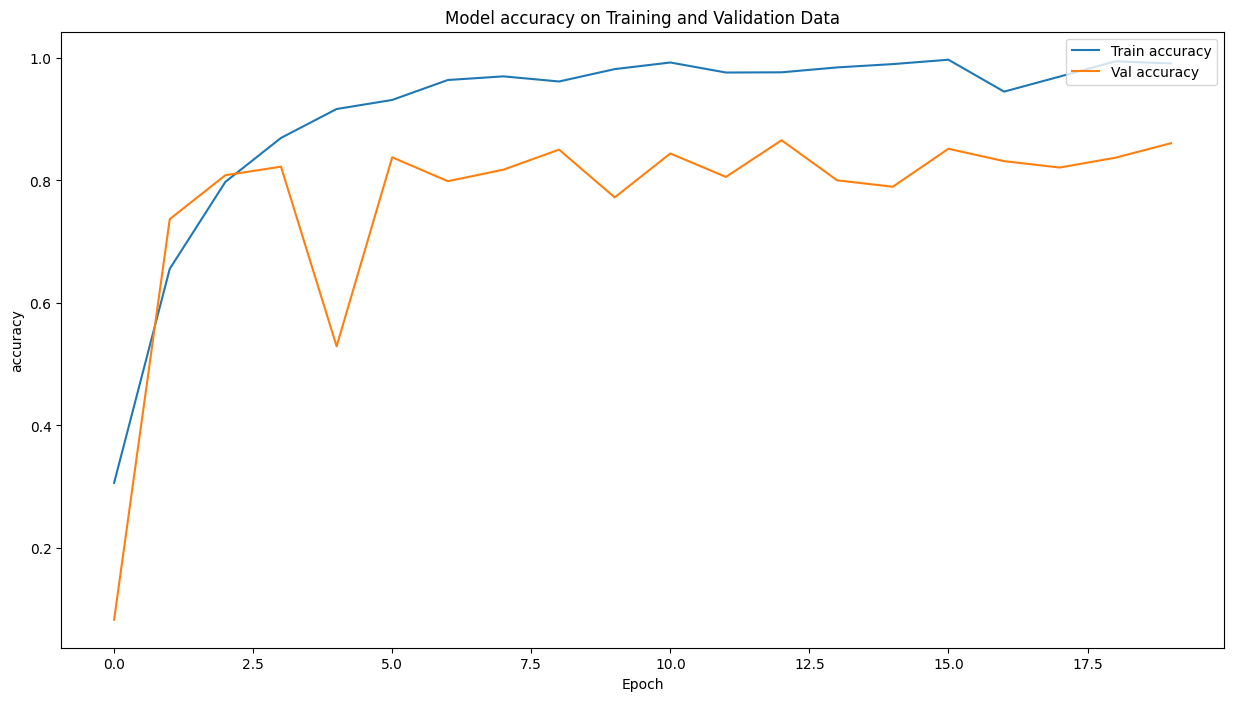

In [64]:
plt.figure(figsize=(15,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy on Training and Validation Data')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train accuracy','Val accuracy' ], loc='upper right')
plt.show()

In [63]:
ccr = model.evaluate(X_test, y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(ccr[0], ccr[1]))


97/97 [==============================] - 30s 304ms/step - loss: 1.6340 - accuracy: 0.8375
Test set
  Loss: 1.634
  Accuracy: 0.838


In [65]:
import numpy as np
from sklearn.metrics import classification_report

# Supongamos que model.predict devuelve las probabilidades de clase para cada muestra
y_pred_probabilities = model.predict(X_test)

# Utiliza argmax para obtener las clases predichas
y_pred = np.argmax(y_pred_probabilities, axis=1)

# Utiliza classification_report para obtener un informe detallado
report = classification_report(np.argmax(y_test, axis=1), y_pred)

# Imprime el informe
print("Classification Report:\n", report)



97/97 [==============================] - 17s 162ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.34      0.20      0.25       152
           1       0.18      0.17      0.17       223
           2       0.90      0.93      0.92      2702

    accuracy                           0.84      3077
   macro avg       0.47      0.43      0.45      3077
weighted avg       0.82      0.84      0.83      3077



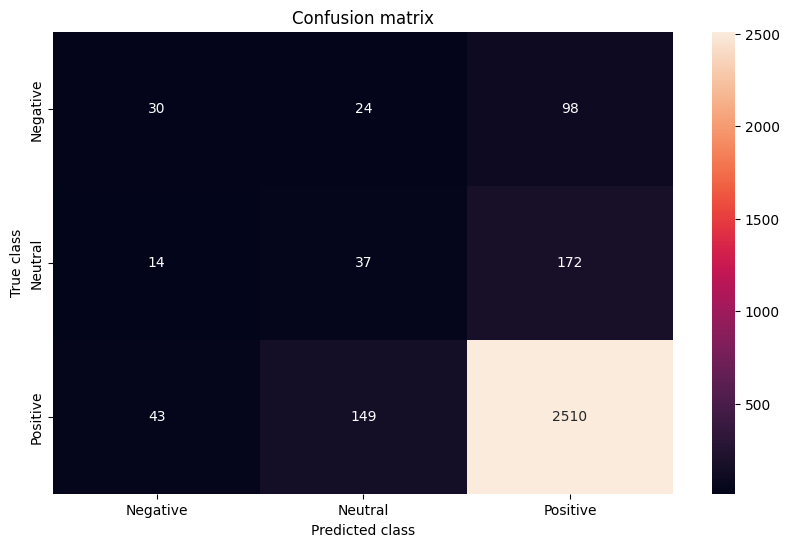

In [66]:
from sklearn.metrics import confusion_matrix
clases = ["Negative", "Neutral", "Positive"]
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=clases, yticklabels=clases);
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

## Save model

In [ ]:
# import pickle

In [ ]:
# # Save the LSTM model and tokenizer
# with open('lstm_model.pkl', 'wb') as model_file:
#     pickle.dump(model, model_file)

# with open('lstm_tokenizer.pkl', 'wb') as tokenizer_file:
#     pickle.dump(tokenizer, tokenizer_file)